## Movie Genre Classification

Classify a movie genre based on its plot.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".

• The project must be carried out in groups of 4 people.
• Use clear and rigorous procedures.
• The delivery of the project is on March 15th, 2024, 11:59 pm, through email with Github link.
• No projects will be received after the delivery time or by any other means than the one established.




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Cargue de datos

In [3]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk.stem import WordNetLemmatizer
import re
import nltk

np.random.seed(4226)

In [4]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [5]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTraining.describe

<bound method NDFrame.describe of       year                              title  \
3107  2003                               Most   
900   2008          How to Be a Serial Killer   
6724  1941                     A Woman's Face   
4704  1954                    Executive Suite   
2582  1990                      Narrow Margin   
...    ...                                ...   
8417  2010                 Our Family Wedding   
1592  1984                Conan the Destroyer   
1723  1955                             Kismet   
7605  1982                 The Secret of NIMH   
215   2009  Tinker Bell and the Lost Treasure   

                                                   plot  \
3107  most is the story of a single father who takes...   
900   a serial killer decides to teach the secrets o...   
6724  in sweden ,  a female blackmailer with a disfi...   
4704  in a friday afternoon in new york ,  the presi...   
2582  in los angeles ,  the editor of a publishing h...   
...                    

In [6]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [7]:
dataTesting.describe

<bound method NDFrame.describe of        year                       title  \
1      1999         Message in a Bottle   
4      1978            Midnight Express   
5      1996                 Primal Fear   
6      1950                      Crisis   
7      1959                 The Tingler   
...     ...                         ...   
11263  2008       The Fifth Commandment   
11265  2003       Coffee and Cigarettes   
11269  1957                    Pal Joey   
11270  2002  Jonah: A VeggieTales Movie   
11275  1993           Man's Best Friend   

                                                    plot  
1      who meets by fate ,  shall be sealed by fate ....  
4      the true story of billy hayes ,  an american c...  
5      martin vail left the chicago da ' s office to ...  
6      husband and wife americans dr .  eugene and mr...  
7      the coroner and scientist dr .  warren chapin ...  
...                                                  ...  
11263  in bangkok ,  an assassin who

## Limpieza de datos

### Identificación de Stopwords

In [6]:
from nltk.corpus import stopwords
# Descargar las stopwords
nltk.download('stopwords')

# Obtener las stopwords en inglés
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
print(stop_words)

{'such', "don't", 're', 'doesn', 'between', 'can', 'those', "hadn't", 'that', 'had', "she's", "you'd", "you'll", 'myself', 'not', "wasn't", 'for', "shouldn't", "won't", 'theirs', 'yourselves', "wouldn't", 'very', 'him', 'itself', 'no', 'then', 'll', 'this', 'your', "you're", 'is', 'about', 've', 'by', 'once', 'further', 'doing', 'won', 'down', 'was', 'under', 'i', 'our', 'in', 'above', 'hasn', 'before', 'aren', 'her', "mustn't", 'be', 'these', 'just', 'themselves', 'needn', 'you', 'too', 'only', 'what', 'of', 'don', 'shan', 'on', 'does', 'y', 'both', 'they', 'ain', 'whom', 'a', 'couldn', 'some', 'been', 'will', 'when', 'mustn', 'hadn', 'being', 'over', 'he', 'while', 'ours', 'more', 'didn', 'or', 'have', 'did', 'below', 'after', 'than', 'so', 'it', 'm', 'until', 'haven', 'which', 'and', 'against', "that'll", 'o', 'me', 'own', 's', 'himself', 'my', "shan't", 'herself', "it's", "should've", 'why', "aren't", 'if', 'has', 'ma', 'wouldn', 'the', 'because', 'into', 'weren', 'there', "doesn't

### Limpieza de símbolos

In [8]:
DtaTraining = dataTraining['plot']

In [9]:
import re
DtaTrainingLimpia = [
    ' '.join(word for word in re.sub(r"[.,;:!-]", '', doc.lower()).split() )
    for doc in DtaTraining
]

In [10]:
for linea in DtaTrainingLimpia[:5]:
    print(linea)

most is the story of a single father who takes his eight year old son to work with him at the railroad drawbridge where he is the bridge tender a day before the boy meets a woman boarding a train a drug abuser at the bridge the father goes into the engine room and tells his son to stay at the edge of the nearby lake a ship comes and the bridge is lifted though it is supposed to arrive an hour later the train happens to arrive the son sees this and tries to warn his father who is not able to see this just as the oncoming train approaches his son falls into the drawbridge gear works while attempting to lower the bridge leaving the father with a horrific choice the father then lowers the bridge the gears crushing the boy the people in the train are completely oblivious to the fact a boy died trying to save them other than the drug addict woman who happened to look out her train window the movie ends with the man wandering a new city and meets the woman no longer a drug addict holding a sm

## Lemmatización y Stopwords

In [11]:
lemmatizer = WordNetLemmatizer()
def tokenize_and_lemmatize(text):
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(lemmatized_tokens)

In [12]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

# Ahora DTraining_lematizado_token tendrá el texto lematizado
print(DTraining_lematizado_token[:5])

['story single father take eight year old son work railroad drawbridge bridge tender day boy meet woman boarding train drug abuser bridge father go engine room tell son stay edge nearby lake ship come bridge lifted though supposed arrive hour later train happens arrive son see try warn father able see oncoming train approach son fall drawbridge gear work attempting lower bridge leaving father horrific choice father lower bridge gear crushing boy people train completely oblivious fact boy died trying save drug addict woman happened look train window movie end man wandering new city meet woman longer drug addict holding small baby relevant narrative run parallel namely one female drug addict meet climax tumultuous film', 'serial killer decides teach secret satisfying career video store clerk', 'sweden female blackmailer disfiguring facial scar meet gentleman life beyond mean become accomplice blackmail fall love bitterly resigned impossibility returning affection life change one victim p

## Vectorización

In [15]:
vectNgramas = CountVectorizer(ngram_range=(1, 4))
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 1481576)

## Creación vector y

In [14]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [15]:
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [18]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

## Train multi-class multi-label model

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7318626209362954

## 1. TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(DTraining_lematizado_token)

# Repartir los datos de nuevo con las nuevas características
XTFIDF_train, XTFIDF_test, yTFIDF_train_genres, yTFIDF_test_genres = train_test_split(X_tfidf, y_genres, test_size=0.33, random_state=42)

# Entrenar el modelo con TF-IDF
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(XTFIDF_train, yTFIDF_train_genres)

yTFIDF_pred_genres = clf.predict_proba(XTFIDF_test)

roc_auc_tfidf = roc_auc_score(yTFIDF_test_genres, yTFIDF_pred_genres, average='macro')
print(f"AUC con TF-IDF: {roc_auc_tfidf}")


AUC con TF-IDF: 0.8094747961022325


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Inicializar el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Aumentar el número de características
X_tfidf = tfidf_vectorizer.fit_transform(DTraining_lematizado_token)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_tfidf, X_test_tfidf, y_train_genres, y_test_genres = train_test_split(
    X_tfidf, y_genres, test_size=0.33, random_state=42
)

# Usar GridSearchCV para optimización de hiperparámetros
param_grid = {
    'estimator__n_estimators': [100, 150],  # Notar el prefijo 'estimator__'
    'estimator__max_depth': [None, 10],
}

# Configuración del clasificador
clf = OneVsRestClassifier(RandomForestClassifier(random_state=42, n_jobs=-1))

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train_genres)

best_model = grid_search.best_estimator_

# Predecir y calcular el AUC
y_pred_genres_proba = best_model.predict_proba(X_test_tfidf)
roc_auc = roc_auc_score(y_test_genres, y_pred_genres_proba, average='macro')
print(f"AUC con el mejor modelo: {roc_auc}")


c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


AUC con el mejor modelo: 0.8015708883290121


### 1.1 TF-IDF + Word2Vec

In [20]:
from gensim.models import Word2Vec

In [ ]:
# 1. Crear la matriz TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(DTraining_lematizado_token)

# 2. Repartir los datos
XTFIDF_W2V_train, XTFIDF_W2V_test, yTFIDF_W2V_train_genres, yTFIDF_W2V_test_genres = train_test_split(X_tfidf, y_genres, test_size=0.33, random_state=42)

# 3. Entrenar el modelo con TF-IDF
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(XTFIDF_W2V_train, yTFIDF_W2V_train_genres)

yTFIDF_W2V_pred_genres = clf.predict_proba(XTFIDF_W2V_test)

# 4. Calcular AUC con TF-IDF
roc_auc_tfidf = roc_auc_score(yTFIDF_W2V_test_genres, yTFIDF_W2V_pred_genres, average='macro')
print(f"AUC con TF-IDF: {roc_auc_tfidf}")

# 5. Entrenar el modelo Word2Vec
model_w2v = Word2Vec(sentences=DTraining_lematizado_token, vector_size=100, window=10, min_count=1, workers=4)

# 6. Función para obtener vectores promedio ponderados usando Word2Vec
def get_weighted_average_vector(doc, model, tfidf_vectorizer):
    words = doc.split()
    tfidf_weights = tfidf_vectorizer.transform([doc]).toarray()[0]
    word_vectors = np.array([model.wv[word] for word in words if word in model.wv])

    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Retornar un vector nulo si no hay palabras

    valid_weights = np.array([tfidf_weights[i] for i, word in enumerate(words) if word in model.wv])
    # Verificar si hay pesos válidos
    if np.sum(valid_weights) == 0:
        return np.zeros(model.vector_size)  # Retornar un vector nulo si todos los pesos son cero

    weighted_avg_vector = np.average(word_vectors, axis=0, weights=valid_weights)
    return weighted_avg_vector

# 7. Calcular el vector promedio ponderado para cada documento
document_vectors_train = np.array([get_weighted_average_vector(doc, model_w2v, tfidf) for doc in DTraining_lematizado_token])

# 8. Repartir los datos utilizando los vectores de Word2Vec
X_w2v_train, X_w2v_test, y_w2v_train_genres, y_w2v_test_genres = train_test_split(document_vectors_train, y_genres, test_size=0.33, random_state=42)

# 9. Entrenar el modelo con Word2Vec
clf_w2v = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf_w2v.fit(X_w2v_train, y_w2v_train_genres)

# 10. Predecir y calcular AUC para Word2Vec
y_w2v_pred_genres = clf_w2v.predict_proba(X_w2v_test)
roc_auc_w2v = roc_auc_score(y_w2v_test_genres, y_w2v_pred_genres, average='macro')
print(f"AUC con Word2Vec: {roc_auc_w2v}")


AUC con TF-IDF: 0.8122562459586806
AUC con Word2Vec: 0.5027859894658425


## 2. Modelo Word2Vec

In [21]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

# Tokenizar los datos para Word2Vec
#dataTraining['tokenized_plot'] = dataTraining['plot'].apply(lambda x: x.split())

# Entrenar Word2Vec
word2vec = Word2Vec(sentences=DTraining_lematizado_token, vector_size=100, window=5, min_count=1, workers=4)
X_word2vec = np.array([np.mean([word2vec.wv[word] for word in words if word in word2vec.wv] or [np.zeros(100)], axis=0)
                       for words in DTraining_lematizado_token])

# Escalar los datos
scaler = StandardScaler()
X_word2vec_scaled = scaler.fit_transform(X_word2vec)

# División de los datos
X_trainW2V, X_testW2V, y_trainW2V_genres, y_testW2V_genres = train_test_split(X_word2vec_scaled, y_genres, test_size=0.33, random_state=42)

# Entrenar el modelo
clf_w2v = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf_w2v.fit(X_trainW2V, y_trainW2V_genres)

y_pred_genres_w2v = clf_w2v.predict_proba(X_testW2V)

roc_auc_w2v = roc_auc_score(y_testW2V_genres, y_pred_genres_w2v, average='macro')
print(f"AUC con Word2Vec: {roc_auc_w2v}")


AUC con Word2Vec: 0.5891096079441646


## 4. N-GRAMS + Random Forest con optimización de hiperparametros

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)
    
# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
0.843708257051456


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import roc_auc_score

# Definir un espacio de hiperparámetros más amplio
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2']  # Añadir max_features
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=5, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.p

0.7776074018308646


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

# Crear un clasificador de Random Forest envuelto en OneVsRestClassifier
rf = OneVsRestClassifier(RandomForestClassifier(random_state=42, n_jobs=-1))

# Definir el espacio de hiperparámetros
param_dist = {
    'estimator__n_estimators': [100, 200, 500],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__bootstrap': [True, False],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=5, verbose=1, n_jobs=-1, random_state=42)

# Ajustar el modelo
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)

# Calcular el AUC
auc_score = roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro')
print(f"AUC optimizado con Random Forest: {auc_score}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


### Nuevo codigo

In [24]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(stemmed_tokens)

In [25]:
DTraining_Steam_token = [tokenize_and_stem(doc) for doc in DtaTrainingLimpia]


In [26]:
vectNgramas = CountVectorizer(ngram_range=(1, 4))
X_dtm = vectNgramas.fit_transform(DTraining_Steam_token)
X_dtm.shape

(7895, 1457808)

In [27]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8691220537022973


### Vectorizar el título de la pelicula

In [29]:
Dta_tittle_Training = dataTraining['title']

Dta_tittle_Training_limp = [
    ' '.join(word for word in re.sub(r"[.,;:!-]", '', doc.lower()).split() )
    for doc in Dta_tittle_Training
]

In [30]:
Dta_tittle_token_lem = [tokenize_and_lemmatize(doc) for doc in Dta_tittle_Training_limp]

In [31]:
vectNgramastitle = CountVectorizer(ngram_range=(1, 4))
X_dtm_title = vectNgramastitle.fit_transform(Dta_tittle_token_lem)
X_dtm_title.shape

(7895, 16494)

In [32]:
from scipy.sparse import hstack

# Combinar las dos matrices dispersas en una sola
X_combined = hstack([X_dtm_title, X_dtm])
X_combined.shape

(7895, 1474302)

In [33]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_combined, y_genres, test_size=0.33, random_state=42)

In [34]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8481158431066325


### Reducir ngramas [texto del vínculo](https://)

In [35]:
vectNgramas = CountVectorizer(ngram_range=(1, 3))
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 969539)

In [36]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [37]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8498888324767312


### Reducir mas lo ngrams

In [ ]:
vectNgramas = CountVectorizer(ngram_range=(1, 2))
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 457248)

In [ ]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8547569403554321


### N-Grams con ajuste de min_df

In [16]:
vectNgramas = CountVectorizer(ngram_range=(1, 3),min_df=2)
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 63577)

In [17]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [18]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8566481094218504


### N-Grams con ajuste de max feautres

In [19]:
vectNgramas = CountVectorizer(ngram_range=(1, 3),max_features=900000)
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 900000)

In [20]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [21]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8744663437889036


Gráfico AUC

In [44]:
print(f"Forma de y_train_genres: {y_train_genres.shape}")  # Debe ser (n_samples, n_classes)
print(f"Forma de y_train_pred: {y_train_pred.shape}")      # Debe ser (n_samples, n_classes)
print(f"Forma de y_test_genres: {y_test_genres.shape}")    # Debe ser (n_samples, n_classes)
print(f"Forma de y_val_pred: {y_val_pred.shape}")          # Debe ser (n_samples, n_classes)


Forma de y_train_genres: (5289, 24)
Forma de y_train_pred: (24, 5289, 2)
Forma de y_test_genres: (2606, 24)
Forma de y_val_pred: (24, 2606, 2)


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Predecir probabilidades para el conjunto de entrenamiento y validación usando el mejor modelo
best_model = random_search.best_estimator_  # Obtener el mejor modelo

# Predecir probabilidades para el conjunto de entrenamiento
y_train_pred = best_model.predict_proba(X_train)
y_val_pred = best_model.predict_proba(X_test)

# Asegurarse de que las predicciones están en formato NumPy
y_train_pred = np.array(y_train_pred)  # Convertir a un array NumPy
y_val_pred = np.array(y_val_pred)      # Convertir a un array NumPy

# Transponer y ajustar dimensiones si es necesario
y_train_pred = y_train_pred.transpose(1, 0, 2).reshape(-1, 2)  # Ajusta según sea necesario
y_val_pred = y_val_pred.transpose(1, 0, 2).reshape(-1, 2)

# Imprimir las formas de las etiquetas y las predicciones para verificar
print(f"Forma de y_train_genres: {y_train_genres.shape}")
print(f"Forma de y_train_pred: {y_train_pred.shape}")
print(f"Forma de y_test_genres: {y_test_genres.shape}")
print(f"Forma de y_val_pred: {y_val_pred.shape}")

# Asegúrate de acceder a la probabilidad de la clase positiva
class_index = 1  # Cambia esto al índice de la clase que quieres evaluar

# Calcular AUC para el conjunto de entrenamiento
train_fpr, train_tpr, _ = roc_curve(y_train_genres[:, class_index], y_train_pred[:, class_index])
train_auc = auc(train_fpr, train_tpr)

# Calcular AUC para el conjunto de validación
val_fpr, val_tpr, _ = roc_curve(y_test_genres[:, class_index], y_val_pred[:, class_index])
val_auc = auc(val_fpr, val_tpr)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, color='blue', label=f'Train AUC: {train_auc:.2f}')
plt.plot(val_fpr, val_tpr, color='orange', label=f'Validation AUC: {val_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea diagonal
plt.title('Curvas ROC de Entrenamiento y Validación')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Calcular el AUC final para el conjunto de prueba
final_auc = roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro')
print(f"AUC final en el conjunto de prueba: {final_auc}")


Forma de y_train_genres: (5289, 24)
Forma de y_train_pred: (126936, 2)
Forma de y_test_genres: (2606, 24)
Forma de y_val_pred: (62544, 2)


ValueError: Found input variables with inconsistent numbers of samples: [5289, 126936]

### Aumentar Ngram

In [ ]:
vectNgramas = CountVectorizer(ngram_range=(1, 5))
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 1986378)

In [ ]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.824057783577559


In [ ]:
vectNgramas = CountVectorizer()
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 34446)

In [ ]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8511364099607438


## 5. Glove

In [38]:
import gensim.downloader as api
from gensim.models import Word2Vec

In [39]:
model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
import numpy as np

# Función para convertir una lista de palabras en un vector promedio usando Word2Vec
def get_avg_word2vec(tokens, model, vector_size=100):
    vector = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model:
            vector += model[word]
            count += 1
    if count > 0:
        vector /= count
    return vector

# Aplicar la función a los títulos o descripciones de las películas
X_dtm = np.array([get_avg_word2vec(DTraining_lematizado_token, model) for doc in DTraining_lematizado_token])

In [ ]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.5


## 6. Word2Vec

In [ ]:
import numpy as np
from gensim.models import Word2Vec

# Entrenar el modelo Word2Vec con 1000 dimensiones
word2vec = Word2Vec(sentences=DTraining_lematizado_token,   vector_size=1000, window=3, min_count=1, workers=4)

# Crear los vectores promedio para cada documento
X_word2vec = np.array([np.mean([word2vec.wv[word] for word in words if word in word2vec.wv] or [np.zeros(1000)], axis=0)
                       for words in DTraining_lematizado_token])

print(X_word2vec.shape)  # Verifica la forma del resultado

(7895, 1000)


In [ ]:
np.random.seed(4226)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_word2vec, y_genres, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.6199157824416826


## 7. ONE HOT

In [ ]:
DtaTraining = dataTraining['plot'] + ' ' + dataTraining['title']

In [ ]:
import re
DtaTrainingLimpia = [
    ' '.join(word for word in re.sub(r"[.,;:!-]", '', doc.lower()).split() )
    for doc in DtaTraining
]

In [ ]:
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

In [ ]:
vectNgramas = CountVectorizer(ngram_range=(1, 3))
X_dtm = vectNgramas.fit_transform(DTraining_lematizado_token)
X_dtm.shape

(7895, 997880)

In [ ]:
# Prepare 'year' feature
scaler = MinMaxScaler()
X_year = scaler.fit_transform(dataTraining[['year']])

In [ ]:
np.random.seed(4226)
X_train, X_test,X_train_year, X_test_year, y_train_genres, y_test_genres = train_test_split(X_dtm,X_year, y_genres, test_size=0.33, random_state=42)

In [ ]:
# Combine features
X_train_combined = hstack([X_train, X_train_year])
X_test_combined = hstack([X_test, X_test_year])

In [ ]:
# Classifier with adjusted parameters
clf = OneVsRestClassifier(LogisticRegression(C=1.0, solver='lbfgs', max_iter=2000))

# Train the classifier
clf.fit(X_train_combined, y_train_genres)

# Evaluate the model
y_score = clf.decision_function(X_test_combined)



In [ ]:
auc_scores = []
for i in range(y_genres.shape[1]):
    auc = roc_auc_score(y_test_genres[:, i], y_score[:, i])
    auc_scores.append(auc)

average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

Average AUC: 0.87


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Entrenar con los mejores parámetros
random_search.fit(X_train_combined, y_train_genres)

# Predecir y calcular AUC
y_pred_genres_optimized = random_search.predict_proba(X_test_combined)
# Acceder a las probabilidades de la clase positiva (segunda columna)
y_pred_genres_optimized = random_search.predict_proba(X_test_combined)
y_pred_genres_optimized = np.array([proba[:, 1] for proba in y_pred_genres_optimized]).T

# Calcular el AUC
print(roc_auc_score(y_test_genres, y_pred_genres_optimized, average='macro'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8798355545148496


## 5. BOW + Red Neuronal Sencilla

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
count_vect = CountVectorizer()
#Build a BOW representation for the corpus
bow_X = count_vect.fit_transform(DTraining_lematizado_token)

print("Our vocabulary: ", count_vect.vocabulary_)  

Our vocabulary:  {'story': 29453, 'single': 28071, 'father': 11003, 'take': 30274, 'eight': 9609, 'year': 34185, 'old': 21745, 'son': 28624, 'work': 33995, 'railroad': 24728, 'drawbridge': 9119, 'bridge': 3770, 'tender': 30574, 'day': 7507, 'boy': 3579, 'meet': 19561, 'woman': 33934, 'boarding': 3275, 'train': 31332, 'drug': 9211, 'abuser': 115, 'go': 12754, 'engine': 9995, 'room': 26341, 'tell': 30536, 'stay': 29232, 'edge': 9529, 'nearby': 20979, 'lake': 17291, 'ship': 27772, 'come': 5890, 'lifted': 17885, 'though': 30832, 'supposed': 29917, 'arrive': 1517, 'hour': 14599, 'later': 17445, 'happens': 13636, 'see': 27316, 'try': 31664, 'warn': 33305, 'able': 55, 'oncoming': 21802, 'approach': 1322, 'fall': 10859, 'gear': 12394, 'attempting': 1774, 'lower': 18342, 'leaving': 17594, 'horrific': 14536, 'choice': 5248, 'crushing': 7086, 'people': 22837, 'completely': 6028, 'oblivious': 21584, 'fact': 10786, 'died': 8321, 'trying': 31665, 'save': 26894, 'addict': 295, 'happened': 13634, 'loo

In [26]:
XBOW_train, XBOW_test, yBOW_train_genres, yBOW_test_genres = train_test_split(
    bow_X, y_genres, test_size=0.33, random_state=42)

# Verificar el tamaño de los conjuntos
print(XBOW_train.shape, yBOW_train_genres.shape)  # Deben tener la misma cantidad de muestras
print(XBOW_test.shape, yBOW_test_genres.shape)

(5289, 34461) (5289, 24)
(2606, 34461) (2606, 24)


In [27]:
def modelo_red2_keras(CE_x, CE_y, CV_x, CV_y, n_h, num_iter, tasa, dropout_rate, batch_size, semilla, print_c):
    np.random.seed(semilla)
    tf.random.set_seed(semilla)

    model = Sequential()    
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    model.add(Dense(units=n_h, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Ajustar la salida para multilabel
    model.add(Dense(CE_y.shape[1], activation='sigmoid'))  # Número de salidas igual al número de etiquetas
    # Usar binary_crossentropy para multilabel
    model.compile(optimizer=Adam(learning_rate=tasa), loss='binary_crossentropy', metrics=['AUC'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    history = model.fit(CE_x, CE_y, validation_data=(CV_x, CV_y), batch_size=batch_size, epochs=num_iter, verbose=1 if print_c else 0, callbacks=[early_stopping])
    
    param = model.get_weights()
    epoc = np.argmin(history.history['val_loss']) + 1  # Mejor época basada en validación
    return model, param, epoc, history

In [28]:
# Convertir las matrices dispersas en matrices densas
XBOW_train_dense = XBOW_train.toarray()
XBOW_test_dense = XBOW_test.toarray()

# Entrenar el modelo con las matrices densas
model, param, epoc, history = modelo_red2_keras(
    XBOW_train_dense, yBOW_train_genres, XBOW_test_dense, yBOW_test_genres,
    n_h=428,  # número de neuronas en la capa oculta
    num_iter=163,  # número de épocas
    tasa=3.9563664553994944e-05,  # tasa de aprendizaje
    dropout_rate=0.2948388655655226,  # tasa de dropout
    batch_size=325,  # tamaño de batch
    semilla=42,
    print_c=True
)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - AUC: 0.4522 - loss: 0.6885 - val_AUC: 0.5237 - val_loss: 0.6669
Epoch 2/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - AUC: 0.5653 - loss: 0.6582 - val_AUC: 0.5908 - val_loss: 0.6388
Epoch 3/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - AUC: 0.6259 - loss: 0.6285 - val_AUC: 0.6226 - val_loss: 0.6087
Epoch 4/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - AUC: 0.6523 - loss: 0.5967 - val_AUC: 0.6396 - val_loss: 0.5770
Epoch 5/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - AUC: 0.6732 - loss: 0.5635 - val_AUC: 0.6503 - val_loss: 0.5455
Epoch 6/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - AUC: 0.6827 - loss: 0.5313 - val_AUC: 0.6584 - val_loss: 0.5159
Epoch 7/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - AUC: 0.6935 - loss: 0.5016 - val_AUC: 0.6657 - val_loss: 0.4890
Epoch 8/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - AUC: 0.7027 - loss: 0.4742 - val_AUC: 0.6730 - val_loss: 0.4652
Epoch 9/163
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/

In [29]:
# Evaluación del modelo en conjunto de validación
loss, auc = model.evaluate(XBOW_test_dense, yBOW_test_genres)
print(f"Loss en validación: {loss}")
print(f"AUC en validación: {auc}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.8761 - loss: 0.2439
Loss en validación: 0.2456062138080597
AUC en validación: 0.8715668320655823


Gráfico de AUC y Loss

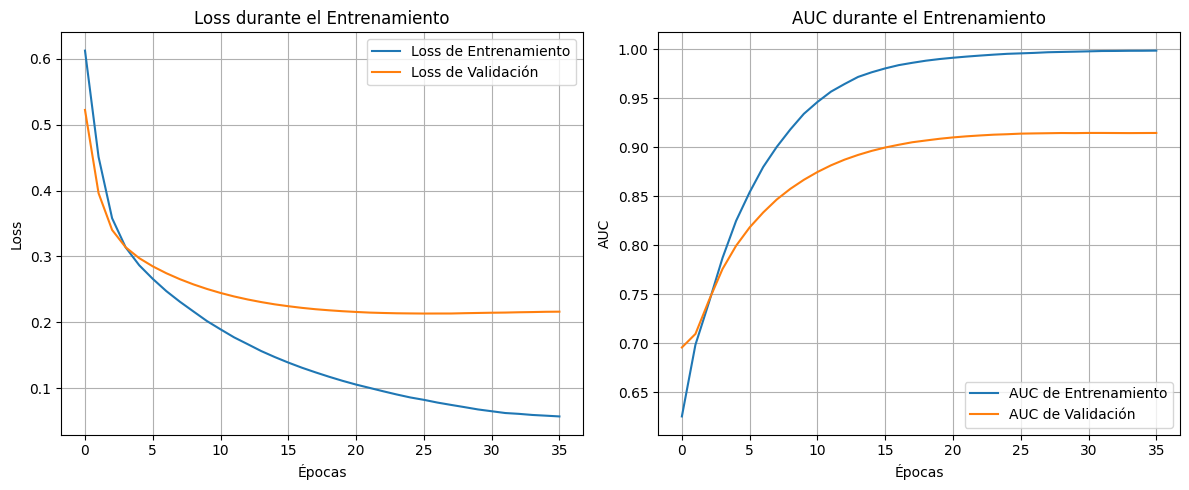

In [66]:
import matplotlib.pyplot as plt

# Gráfico de pérdida (loss)
plt.figure(figsize=(12, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()

# Gráfico de AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='AUC de Entrenamiento')
plt.plot(history.history['val_auc'], label='AUC de Validación')
plt.title('AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.grid()

# Mostrar los gráficos
plt.tight_layout()
plt.show()



## 6. BOW + Glove + RN Sencilla


In [30]:
DtaTraining = dataTraining['plot'] + ' ' + dataTraining['title']

In [31]:
import re
DtaTrainingLimpia = [
    ' '.join(word for word in re.sub(r"[.,;:!-]", '', doc.lower()).split() )
    for doc in DtaTraining
]

In [32]:
DTraining_lematizado_token = [tokenize_and_lemmatize(doc) for doc in DtaTrainingLimpia]

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import urllib.request
import warnings
from tensorflow.keras.layers import Dense, Flatten, Dropout
import random
from tensorflow.keras.regularizers import l1_l2
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [34]:
import gensim.downloader as api
# Download embeddings (66MB, glove, trained on wikipedia)
glove_model = api.load("glove-wiki-gigaword-50")

In [35]:
np.random.seed(4226)

# Crear una función para obtener el embedding promedio de GloVe
def get_average_embedding(text, model):
    embeddings = []
    for word in text.split():
        if word in model:
            embeddings.append(model[word])
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    return np.mean(embeddings, axis=0)

# Vectorización sencilla con Bag of Words
count_vect = CountVectorizer()
bow_X = count_vect.fit_transform(DTraining_lematizado_token)

# Crear la matriz de embeddings de GloVe
glove_X = np.array([get_average_embedding(text, glove_model) for text in DTraining_lematizado_token])

# Combinar ambas representaciones Glove y BOW
combined_X = np.hstack((bow_X.toarray(), glove_X))

# Dividir los datos en conjuntos de entrenamiento y prueba
XBOW_train, XBOW_test, yBOW_train_genres, yBOW_test_genres = train_test_split(
    combined_X, y_genres, test_size=0.33, random_state=42)

# Verificar el tamaño de los conjuntos, que coincidan para no generar errores por diferencia en tamaños
print(XBOW_train.shape, yBOW_train_genres.shape)
print(XBOW_test.shape, yBOW_test_genres.shape)


(5289, 35477) (5289, 24)
(2606, 35477) (2606, 24)


In [36]:
np.random.seed(4226)
#Modelo de RN usado en el proyecto 1

def modelo_red2_keras(CE_x, CE_y, CV_x, CV_y, n_h, num_iter, tasa, dropout_rate, batch_size, semilla, print_c):
    np.random.seed(semilla)
    tf.random.set_seed(semilla)

    model = Sequential()
    model.add(Flatten(input_shape=CE_x.shape[1:]))
    
    # Capa oculta sin BatchNormalization
    model.add(Dense(units=n_h, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout ajustado o eliminado
    
    # Capa de salida
    model.add(Dense(CE_y.shape[1], activation='sigmoid'))
    
    # Optimización con Adam y tasa de aprendizaje ajustada
    model.compile(optimizer=Adam(learning_rate=tasa), loss='binary_crossentropy', metrics=['AUC'])

    # Callbacks: EarlyStopping y ReduceLROnPlateau para optimizar el entrenamiento
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # Entrenamiento
    history = model.fit(CE_x, CE_y, validation_data=(CV_x, CV_y), 
                        batch_size=batch_size, epochs=num_iter, 
                        verbose=1 if print_c else 0, callbacks=[early_stopping, reduce_lr])

    param = model.get_weights()
    epoc = np.argmin(history.history['val_loss']) + 1
    return model, param, epoc, history

# Entrenar el modelo simplificado
model, param, epoc, history = modelo_red2_keras(
    XBOW_train, yBOW_train_genres, XBOW_test, yBOW_test_genres,
    n_h=256,  # número de neuronas ajustado en la capa oculta
    num_iter=100,  # número de épocas ajustado
    tasa=1e-4,  # tasa de aprendizaje ajustada
    dropout_rate=0.2,  # tasa de dropout ajustada
    batch_size=128,  # tamaño de batch ajustado
    semilla=42,
    print_c=True
)

# Evaluar el modelo
loss, auc = model.evaluate(XBOW_test, yBOW_test_genres)
print(f"Loss en validación: {loss}")
print(f"AUC en validación: {auc}")

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - AUC: 0.6088 - loss: 0.6497 - val_AUC: 0.6773 - val_loss: 0.5208 - learning_rate: 1.0000e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - AUC: 0.6876 - loss: 0.4802 - val_AUC: 0.7089 - val_loss: 0.3938 - learning_rate: 1.0000e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - AUC: 0.7345 - loss: 0.3709 - val_AUC: 0.7479 - val_loss: 0.3381 - learning_rate: 1.0000e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - AUC: 0.7819 - loss: 0.3199 - val_AUC: 0.7781 - val_loss: 0.3126 - learning_rate: 1.0000e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - AUC: 0.8197 - loss: 0.2910 - val_AUC: 0.8003 - val_loss: 0.2970 - learning_rate: 1.0000e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - AUC: 0.8499 - loss: 0.2697 - val_AUC: 0.8188 - val_loss: 0.2850 - learning_rate: 1.0000e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - AUC: 0.8753 - loss: 0.2518 - val_AUC: 0.8340 - val_loss: 0.2749

Gráficas de AUC y Loss

In [38]:
print(history.history.keys())

dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss', 'learning_rate'])


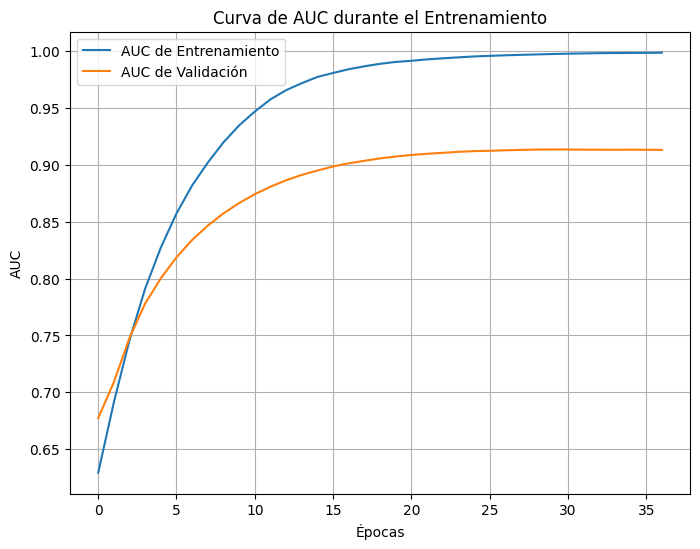

In [39]:
import matplotlib.pyplot as plt

# Gráfico de AUC
plt.figure(figsize=(8, 6))
plt.plot(history.history['AUC'], label='AUC de Entrenamiento')
plt.plot(history.history['val_AUC'], label='AUC de Validación')
plt.title('Curva de AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.show()

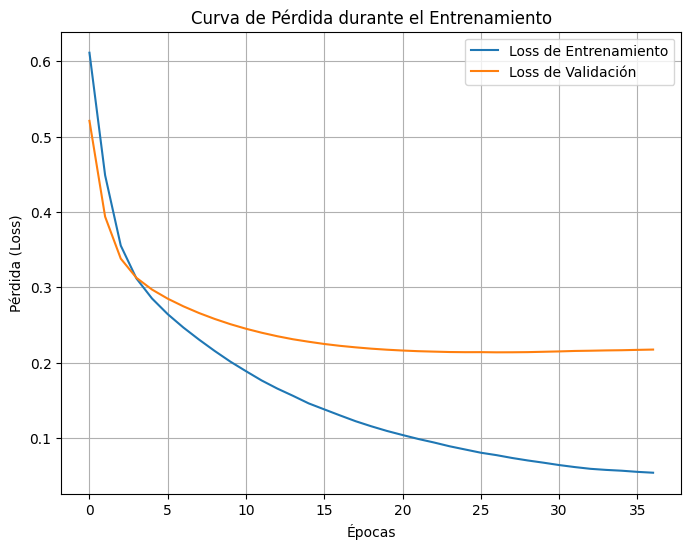

In [40]:
# Graficar Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss de Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de Validación')
plt.title('Curva de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid()
plt.show()

## Cálculo de Precisión del modelo

In [41]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

# Obtener las predicciones del modelo (probabilidades)
y_pred_prob = model.predict(XBOW_test)

# Convertir las probabilidades a clases (umbral = 0.6)
y_pred_classes = (y_pred_prob >= 0.6).astype(int)

# Calcular la exhaustividad
exhaustividad = recall_score(yBOW_test_genres, y_pred_classes, average='macro')
accuracy = accuracy_score(yBOW_test_genres, y_pred_classes)
precision = precision_score(yBOW_test_genres, y_pred_classes, average='weighted')

print(f"Precisión del modelo: {precision:.2f}")
#print(f"Exhaustividad (Recall) del modelo: {exhaustividad:.2f}")
#print(f"Accuracy (Recall) del modelo: {accuracy:.2f}")


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Precisión del modelo: 0.75


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
